V3: 
+ Delete the stop words
+ LSTM uses the Tokenizert.fit_on_texts(data) then Tokenizert.texts_to_sequences(data) to do the preprocessing
+ Other models uses the TfidfVectorizer to do the the preprocessing
    

Goal of this notebook to test several classifiers on the data set with different features 

### Let's begin

First of all neccesary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

Let's read the data from csv file

In [2]:
sms = pd.read_csv('../data/sms-spam.csv',delimiter=',',encoding='latin-1')

sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [3]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [4]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's create new feature "message length" and plot it to see if it's of any interest

In [5]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


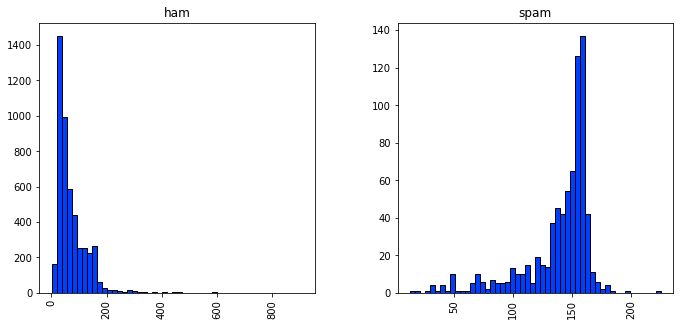

In [6]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))
plt.savefig("../img/sms-length-distribution.eps")
plt.show()

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [7]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [8]:
# def text_process(text):
    
#     text = text.translate(str.maketrans('', '', string.punctuation))
#     text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
#     return " ".join(text)

In [9]:
# text_feat = text_feat.apply(text_process)

In [10]:
vectorizer = TfidfVectorizer("english")

In [11]:
features = vectorizer.fit_transform(text_feat)

In [12]:
labels = LabelEncoder().fit_transform(sms['label'])
labels = labels.reshape(-1,1)

In [13]:
text_feat.shape

(5572,)

In [14]:
features.shape

(5572, 9403)

###  Classifiers and predictions

First of all let's split our features to test and train set

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [18]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [19]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [20]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [21]:
import time

In [22]:
pred_scores = []
for k,v in clfs.items():
    since = time.time()
   
    train_classifier(v, features_train, labels_train)
    time_elapsed = time.time() - since
    
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [precision_score(labels_test,pred), recall_score(labels_test,pred), accuracy_score(labels_test,pred), f1_score(labels_test,pred), '{:.0f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60)]))

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was ex

In [23]:
# pred_scores

In [24]:
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Precision', 'Recall', 'Accuracy', 'F1', 'Training Time (s)'])
df

,Precision,Recall,Accuracy,F1,Training Time (s)
SVC,0.980198,0.853448,0.977273,0.912442,0m 2.1878s
KN,0.990826,0.465517,0.925239,0.633431,0m 0.0033s
NB,0.951965,0.939655,0.985048,0.945770,0m 0.0040s
DT,0.866972,0.814655,0.956938,0.840000,0m 0.1719s
LR,0.900621,0.625000,0.938397,0.737913,0m 0.0107s
RF,1.000000,0.827586,0.976077,0.905660,0m 1.2805s
AdaBoost,0.967213,0.762931,0.963517,0.853012,0m 2.4911s
BgC,0.910798,0.836207,0.965909,0.871910,0m 1.0026s
ETC,1.000000,0.788793,0.970694,0.881928,0m 0.9163s


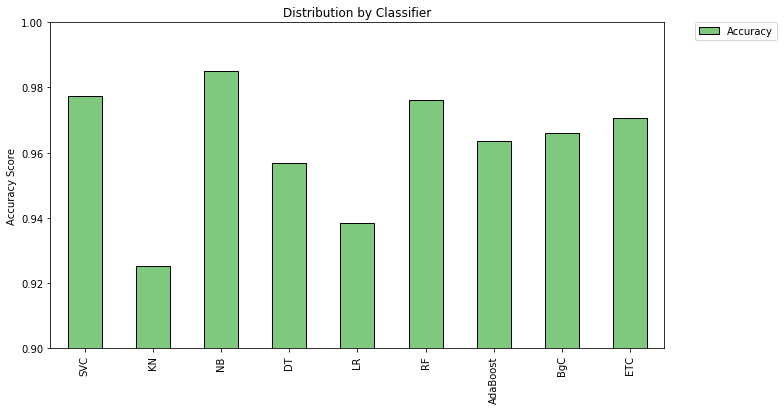

In [25]:
df.plot(kind='bar', y="Accuracy", ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../img/sms-acc-basemodel-v3.eps")
plt.show()

Looks like ensemble classifiers are not doing as good as expected.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [26]:
from sklearn.ensemble import VotingClassifier

In [27]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [28]:
eclf.fit(features_train,labels_train)

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('BgC', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=9, n_jobs=1, oob_score=False, random_state=111,
         verbose=0, warm_start=False)), ('ETC', ExtraTreesClassifier(bootstrap=False,...hm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=62, random_state=111))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [29]:
pred = eclf.predict(features_test)

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
print(precision_score(labels_test,pred), recall_score(labels_test,pred), accuracy_score(labels_test,pred), f1_score(labels_test,pred))

0.9897959183673469 0.8362068965517241 0.9760765550239234 0.9065420560747662


Better but nope.

### RNN
Define the RNN structure.

In [31]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback


Using TensorFlow backend.


### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 500 is chosen. (From the Fig, almost all the sentences have the length < 200)

In [32]:
features_lstm = text_feat
labels_lstm = labels

In [33]:
max_words = 1000
max_len = 200 # n_features
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(features_lstm)
sequences = tok.texts_to_sequences(features_lstm)
features_lstm = sequence.pad_sequences(sequences,maxlen=max_len)

In [34]:
features_lstm.shape

(5572, 200)

In [35]:
labels_lstm.shape

(5572, 1)

In [36]:
features_lstm_train, features_lstm_test, labels_lstm_train, labels_lstm_test = train_test_split(features_lstm, labels_lstm, test_size=0.3, random_state=111, stratify=labels_lstm)


In [37]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [38]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [39]:
since = time.time()
    

model.fit(features_lstm_train, labels_lstm_train, epochs=10, batch_size=128,validation_split=0.2,
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

time_elapsed = time.time() - since

Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 7s 2ms/step - loss: 0.3836 - acc: 0.8603 - val_loss: 0.2437 - val_acc: 0.8910
Epoch 2/10
3120/3120 [==============================] - 6s 2ms/step - loss: 0.1567 - acc: 0.9484 - val_loss: 0.0883 - val_acc: 0.9808
Epoch 3/10
3120/3120 [==============================] - 6s 2ms/step - loss: 0.0691 - acc: 0.9821 - val_loss: 0.0745 - val_acc: 0.9808
Epoch 4/10
3120/3120 [==============================] - 6s 2ms/step - loss: 0.0476 - acc: 0.9865 - val_loss: 0.0712 - val_acc: 0.9821
Epoch 5/10
3120/3120 [==============================] - 6s 2ms/step - loss: 0.0381 - acc: 0.9875 - val_loss: 0.0677 - val_acc: 0.9833
Epoch 6/10
3120/3120 [==============================] - 6s 2ms/step - loss: 0.0272 - acc: 0.9910 - val_loss: 0.0995 - val_acc: 0.9821


In [40]:
print('Training complete in {:.0f}m {:.4f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 

Training complete in 0m 36.6273s


In [41]:
pred = (np.asarray(model.predict(features_lstm_test, batch_size=128))).round()

In [42]:
pred_scores.append(("LSTM", [precision_score(labels_lstm_test,pred), recall_score(labels_lstm_test,pred), accuracy_score(labels_lstm_test,pred), f1_score(labels_lstm_test,pred), '{:.0f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60)]))


### gcForest

In [26]:
import sys
sys.path.append("..") 
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json

In [27]:
def get_toy_config():
    config = {}
    ca_config = {}
    ca_config["random_state"] = 111
    ca_config["max_layers"] = 10
    ca_config["early_stopping_rounds"] = 3
    ca_config["n_classes"] = 2
    ca_config["estimators"] = []
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 31, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "MultinomialNB", "alpha": 0.2})

    config["cascade"] = ca_config
    return config

In [28]:
config = get_toy_config()
gc = GCForest(config)

# features_train 为 ndarray，labels_train 维度为 (n_samples, )，而不是(n_samples, 1)
features_train = features_train.toarray()
labels_train = labels_train.reshape(-1)

since = time.time()
gc.fit_transform(features_train, labels_train)

time_elapsed = time.time() - since

# gc.fit_transform(features_train, labels_train, features_test, labels_test)

[ 2019-04-23 15:46:01,419][cascade_classifier.fit_transform] X_groups_train.shape=[(3900, 9403)],y_train.shape=(3900,),X_groups_test.shape=no_test,y_test.shape=no_test
[ 2019-04-23 15:46:01,705][cascade_classifier.fit_transform] group_dims=[9403]
[ 2019-04-23 15:46:01,706][cascade_classifier.fit_transform] group_starts=[0]
[ 2019-04-23 15:46:01,707][cascade_classifier.fit_transform] group_ends=[9403]
[ 2019-04-23 15:46:01,708][cascade_classifier.fit_transform] X_train.shape=(3900, 9403),X_test.shape=(0, 9403)
[ 2019-04-23 15:46:02,018][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(3900, 9403), X_cur_test.shape=(0, 9403)
[ 2019-04-23 15:46:06,375][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 5_folds.train_0.predict)=95.51%
[ 2019-04-23 15:46:10,250][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 5_folds.train_1.predict)=98.33%
[ 2019-04-23 15:46:14,218][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 

[ 2019-04-23 15:47:19,935][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 5_folds.train_cv.predict)=98.54%
[ 2019-04-23 15:47:20,277][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_1 - 5_folds.train_0.predict)=98.46%
[ 2019-04-23 15:47:20,677][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_1 - 5_folds.train_1.predict)=98.33%
[ 2019-04-23 15:47:20,952][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_1 - 5_folds.train_2.predict)=98.97%
[ 2019-04-23 15:47:21,524][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_1 - 5_folds.train_3.predict)=97.56%
[ 2019-04-23 15:47:21,824][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_1 - 5_folds.train_4.predict)=99.23%
[ 2019-04-23 15:47:21,825][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_1 - 5_folds.train_cv.predict)=98.51%
[ 2019-04-23 15:47:21,826][cascade_classifier.calc_accuracy] Accuracy(layer_4 - train.classifier_average)=98.51%
[ 2019-04-23 15:4

In [29]:
print('Training complete in {:.0f}m {:.4f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 

Training complete in 1m 36.1932s


In [30]:
pred = predict_labels(gc,features_test.toarray())
pred_scores.append(("DCF", [precision_score(labels_test,pred), recall_score(labels_test,pred), accuracy_score(labels_test,pred), f1_score(labels_test,pred), '{:.0f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60)]))

[ 2019-04-23 15:47:37,660][cascade_classifier.transform] X_groups_test.shape=[(1672, 9403)]
[ 2019-04-23 15:47:37,781][cascade_classifier.transform] group_dims=[9403]
[ 2019-04-23 15:47:37,782][cascade_classifier.transform] X_test.shape=(1672, 9403)
[ 2019-04-23 15:47:37,866][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(1672, 9403)
[ 2019-04-23 15:47:38,800][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(1672, 9407)
[ 2019-04-23 15:47:39,654][cascade_classifier.transform] [layer=2] look_indexs=[0], X_cur_test.shape=(1672, 9407)


In [31]:
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Precision', 'Recall', 'Accuracy', 'F1', 'Training Time (s)'])
df

,Precision,Recall,Accuracy,F1,Training Time (s)
SVC,0.980198,0.853448,0.977273,0.912442,0m 2.1878s
KN,0.990826,0.465517,0.925239,0.633431,0m 0.0033s
NB,0.951965,0.939655,0.985048,0.945770,0m 0.0040s
DT,0.866972,0.814655,0.956938,0.840000,0m 0.1719s
LR,0.900621,0.625000,0.938397,0.737913,0m 0.0107s
RF,1.000000,0.827586,0.976077,0.905660,0m 1.2805s
AdaBoost,0.967213,0.762931,0.963517,0.853012,0m 2.4911s
BgC,0.910798,0.836207,0.965909,0.871910,0m 1.0026s
ETC,1.000000,0.788793,0.970694,0.881928,0m 0.9163s
DCF,0.986239,0.926724,0.988038,0.955556,1m 36.1932s


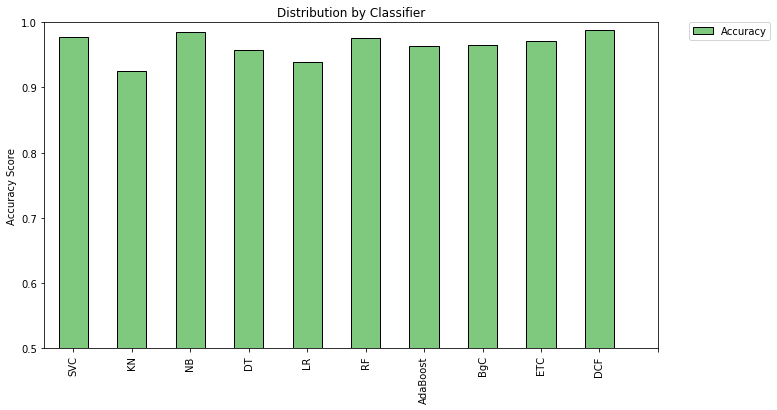

In [32]:
df.plot(kind='bar', y="Accuracy", ylim=(0.5,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(11), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../img/sms-acc-v3.eps")
plt.show()

In [45]:
import pickle
# dump
with open("../pkl/sms-gc-v3.pkl", "wb") as f:
    pickle.dump(gc, f, pickle.HIGHEST_PROTOCOL)
    
# # load
# with open("../pkl/2018_gc.pkl", "rb") as f:
#     gc = pickle.load(f)

### Final verdict - gcForest is your friend in spam detection.